In [1]:

# Requirements: Matplotlib, Numpy, functions_util.py, index.py#, fitting_functions_ZNE.py, h5py

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
#print(os.getcwd())
from util.index import print_index, get_experiment, index_folder
from util.functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from util.fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE


def fit(function, x_axis, y_axis, return_cov=False, p0=[.05,2000000], weights=None):
    # Fit the data to the function
    popt, pcov = curve_fit(function, x_axis, y_axis, p0=p0, sigma=weights, absolute_sigma=True, maxfev=10000)
    
    if return_cov:
        return popt, pcov
    return popt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from util.h5analysis import *
from util.qsim_functions import*


In [3]:

#pairs = [(11,12), (12,13),(13,14)]
#bases = ['x', 'y', 'z']
#pairs_names = [265, 259, 266]
# basis_names = [268, 271, 269]
# foldername = 'Population_4_tw0'
# pairs_names = [str(name) for name in pairs_names]
# qubits = [11,12,13,14]
# shots = 150
foldername = '2_QUBIT_ROTATION_PARITY'
#bases = ['x0', 'y0','x1','y1']

phases = np.array([0, 1/6, 1/3, 1/2, 2/3, 5/6, 1])*np.pi
#phases = np.array([.28/np.pi])*np.pi + np.pi/2

#phases = np.linspace(0, 2*np.pi, 41, endpoint=Tru)
phase_names = [437]#,
phase_names = [422, 424, 425, 426, 430, 431, 432]
qubits = [2,3]
#shots = 600
shots = 600
time_steps = 41



# for name_index in range(len(pairs_names)):
#     name = pairs_names[name_index]
#     if '000563' in pairs_names:
#         pass
#     else:
#         name = '000563' + name
#         pairs_names[name_index] = name
phase_names = [str(name) for name in phase_names]
for name_index in range(len(phase_names)):
    name = phase_names[name_index]
    if '000572' in phase_names:
        pass
    else:
        name = '000572' + name
        phase_names[name_index] = name
full_data_folder_path = './data/' + foldername + '/'


In [4]:
COUNTS_THRESHOLD = 1


In [5]:
measurement_data = np.zeros((time_steps, len(phase_names)), dtype=dict)
#flopping_matrix = np.zeros((30, len(pairs_names)))
#flopping_std_matrix = np.zeros((30, len(pairs_names)))
#times = None

expectations_matrix = np.zeros((time_steps,len(phase_names)))
qubit_0_magnetization = np.zeros((time_steps,len(phase_names)))
leakage_factor = np.zeros((time_steps,len(phase_names)))

print(os.getcwd())
for file_id_index in range(len(phase_names)):
    
    file_id = phase_names[file_id_index]
    phase = phases[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    if file_id_index == 0:
        times_start = times
    if file_id_index == 3:
        times_end = times
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((len(qubits), shots, time_steps))
    for qubit_index in range(len(qubits)):
        qubit = qubits[qubit_index]
        #qubit = pair[pair_index]
        measurements[qubit_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, time_steps), dtype='<U5')
    for i in range(shots):
        for j in range(time_steps):
            bitstring = [str(int(measurements[qubit_index,i,j])) for qubit_index in range(len(qubits))]
            bitstring = "".join(bitstring)
            counts_bitstrings[i,j] = bitstring
    counts_dicts = np.zeros(time_steps, dtype=dict)
    for j in range(time_steps):
        magnetization = 0
        for shot_index in range(shots):
            magnetization += measurements[0, shot_index, j]*2 - 1
        qubit_0_magnetization[j,file_id_index] = magnetization/shots
        temp_dict = {}#
        #{'0000':0, '1111':0}
        for i in range(shots):
            if counts_bitstrings[i,j] in temp_dict:
                temp_dict[counts_bitstrings[i,j]] += 1/shots
            else:
                temp_dict[counts_bitstrings[i,j]] = 1/shots
        counts_dicts[j] = temp_dict
        expectation = 0
        for key in temp_dict.keys():
            #count the number of zeros. If it is even, add the value. If it is odd, subtract the value
            num_zeros = key.count('0')
            if num_zeros % 2 == 0:
                expectation += temp_dict[key]
            else:
                expectation -= temp_dict[key]
        expectations_matrix[j,file_id_index] = expectation
        print(expectation)
    measurement_data[:,file_id_index] = counts_dicts
    
    

    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
(15, 600, 41)
0.8633333333333311
0.8466666666666648
0.7599999999999975
0.6799999999999979
0.48999999999999844
0.4399999999999986
0.27999999999999936
0.08000000000000101
-0.1133333333333319
-0.21999999999999834
-0.20999999999999816
-0.15666666666666468
-0.14333333333333192
-0.039999999999998787
0.136666666666667
0.23666666666666614
0.5533333333333317
0.6233333333333314
0.6933333333333312
0.7866666666666643
0.8199999999999976
0.853333333333331
0.829999999999997
0.7933333333333312
0.6333333333333313
0.5233333333333314
0.453333333333332
0.27333333333333293
0.22333333333333338
0.2133333333333334
0.1266666666666676
0.1533333333333336
0.1433333333333341
0.28333333333333255
0.41999999999999865
0.43999999999999856
0.6299999999999983
0.6566666666666645
0.786666666666664
0.8766666666666642
0.879999999999997
(15, 600, 41)
0.609999999999998
0.5599999999999983
0.3199999999999992
0.17666666666666717
0.00333333333333391
-0.2733333333333313
-0.399999999999998

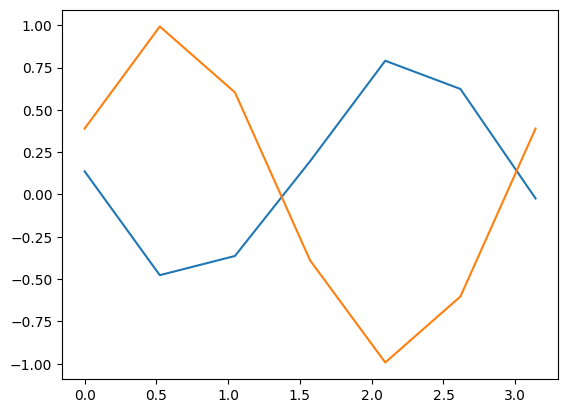

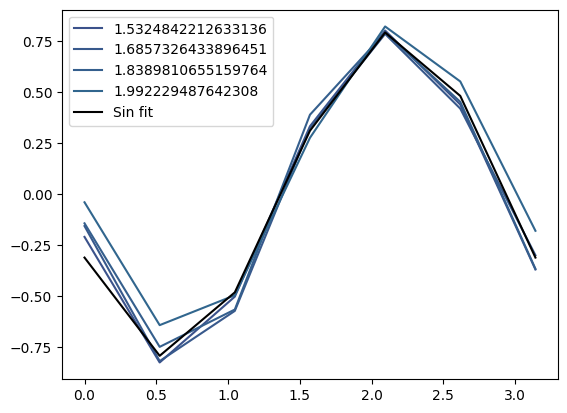

In [6]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(10,14):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
ax.plot(phases, -0.8*np.sin(2*np.array(phases)+0.4), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()

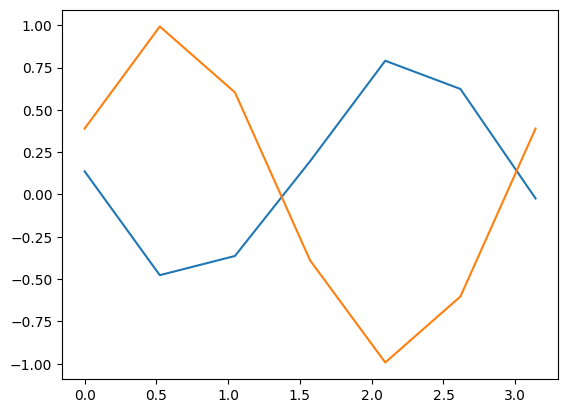

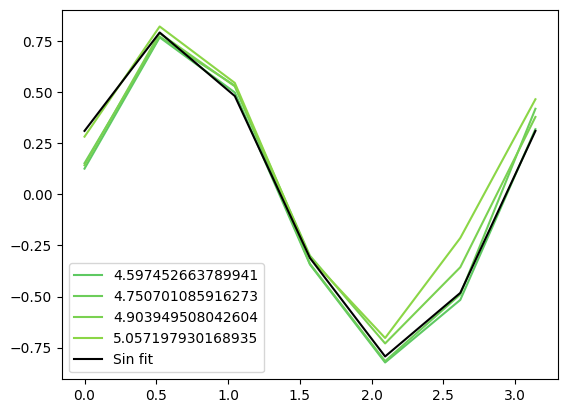

In [7]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(30,34):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
ax.plot(phases, 0.8*np.sin(2*np.array(phases)+0.4), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()

In [8]:
x_axis = [val for val in x_vals]

ValueError: x and y must be the same size

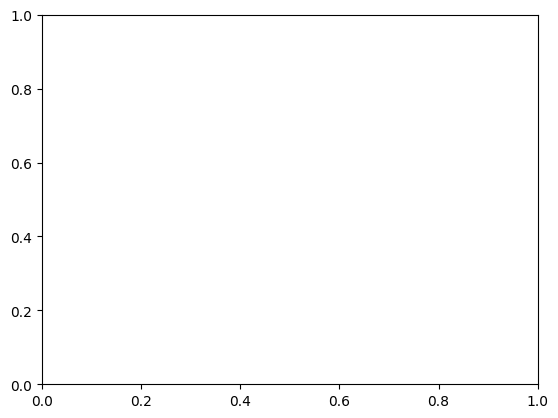

In [9]:
plt.scatter(phases, expectations_matrix[:,0])
#Fit each of the axies to a sign function:

plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))

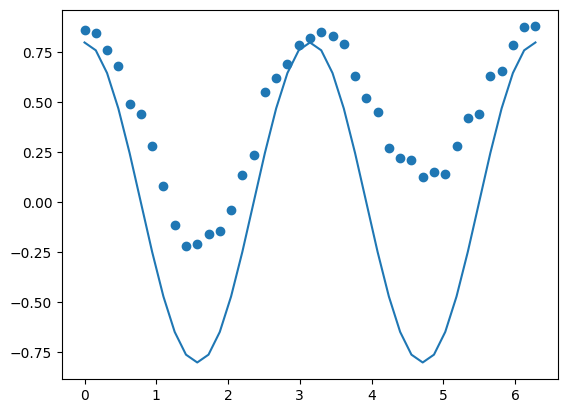

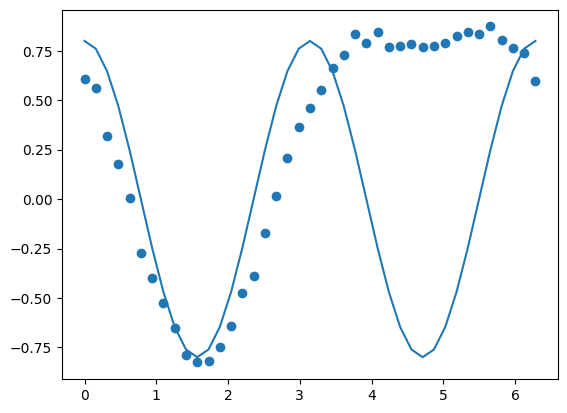

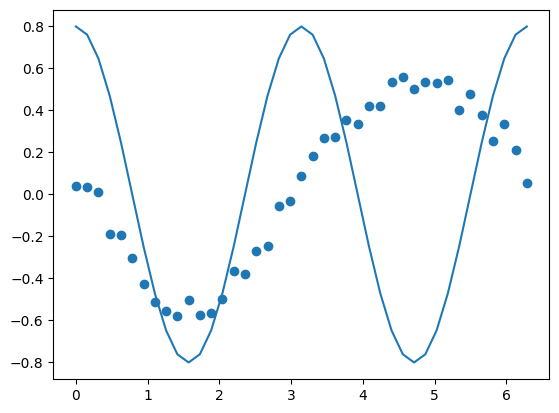

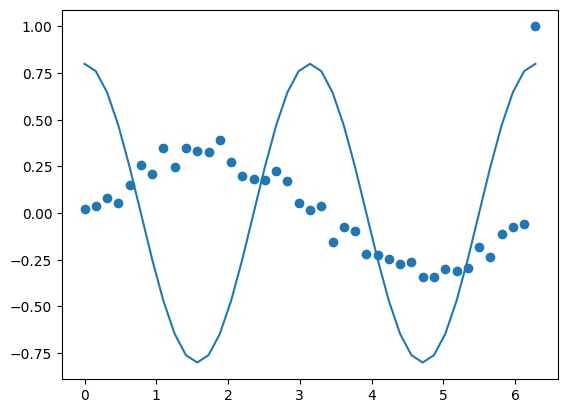

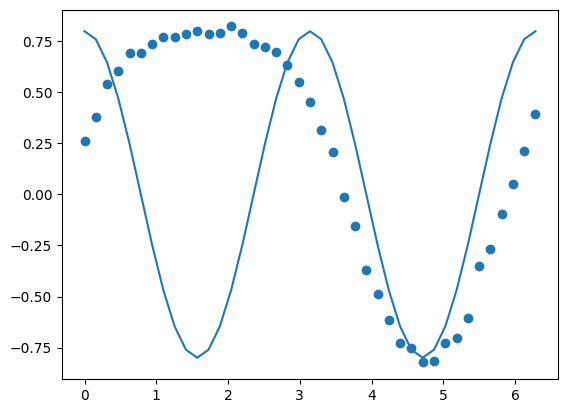

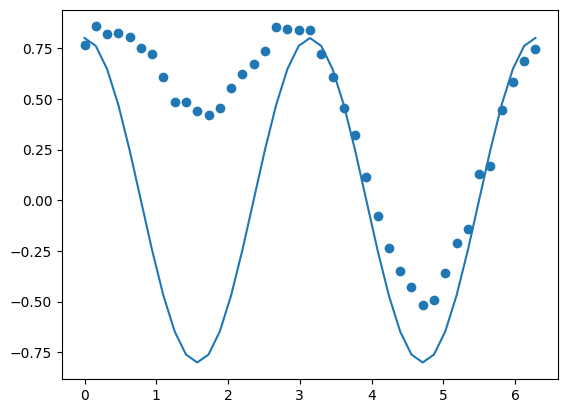

In [ ]:
for i in range(6):
    

    plt.scatter(x_axis, expectations_matrix[:,i])
    #Fit each of the axies to a sign function:

    plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))
    plt.show()

In [ ]:
print(expectations_matrix)

[[ 0.83]
 [ 0.82]
 [ 0.58]
 [ 0.49]
 [ 0.01]
 [ 0.14]
 [-0.12]
 [-0.15]
 [-0.57]
 [-0.57]
 [-0.53]
 [-0.56]
 [-0.43]
 [-0.34]
 [-0.08]
 [ 0.08]
 [ 0.23]
 [ 0.41]
 [ 0.47]
 [ 0.65]
 [ 0.82]
 [ 0.8 ]
 [ 0.92]
 [ 0.9 ]
 [ 0.8 ]
 [ 0.82]
 [ 0.62]
 [ 0.6 ]
 [ 0.6 ]
 [ 0.53]
 [ 0.48]
 [ 0.6 ]
 [ 0.56]
 [ 0.65]
 [ 0.57]
 [ 0.78]
 [ 0.87]
 [ 0.9 ]
 [ 0.85]
 [ 0.77]
 [ 0.8 ]]


TypeError: Improper input: func input vector length N=4 must not exceed func output vector length M=1

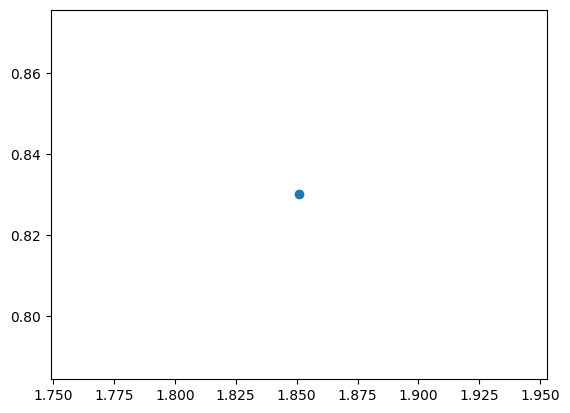

In [ ]:
plt.scatter(phases, expectations_matrix[0,:])
#Fit to a sin function:
def sine(x, A, B, C, D):
    return A*np.sin(B*x + C) + D
phases_sorted = phases.copy()
phases_dense = np.linspace(0, 1.25*np.pi, 1000)
phases_sorted.sort()
popt, pcov = fit(sine, phases, expectations_matrix[0,:], return_cov=True, p0=[.5, 2, 0, 0])
plt.plot(phases_dense, sine(phases_dense, *popt))
print(popt[0])
